# Computer Lab 2: Time Series Cross Validation

**In this computer lab practical you will learn**

* How to apply time series cross validation to select the best forecasting model.

To keep things simple we will work with naive forecasting models.

# Standard Imports

In [11]:
import pandas as pd
import numpy as np

# Forecast-tools imports

In [12]:
from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error

# Exercise 1: Implementing rolling forecast origin time series cross validation.

# Exercise 1.1: Load the data

**Task**:

* Import monthly outpatient appointments time series. This can be found in **"out_appoints_mth.csv"**

**Hints:** 
* This is monthly data.  You can use the Monthly Start ('MS') frequency

In [ ]:
# your code here ...

In [31]:
appoints = pd.read_csv('../../../hpdm097-data/forecasting/out_appoints_mth.csv', 
                   index_col='date', parse_dates=True, dayfirst=True)
appoints.index.freq = 'MS'

In [33]:
appoints.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2014-04-01 to 2018-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   out_apts  49 non-null     int64
dtypes: int64(1)
memory usage: 784.0 bytes


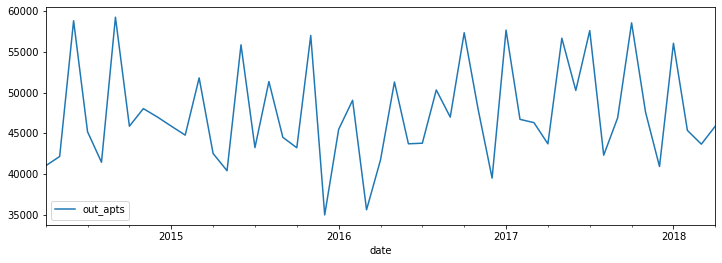

In [32]:
appoints.plot(figsize=(12,4))

# Exercise 1.2. Create a rolling forecast origin in a loop.

In rolling forecast origin we iteratively move our model into the future.  Assume we have the following training data.

```python
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
``` 

If we initially train our model on the first 5 data points and make a 1 step forecast, then a rolling forecast origin look like this:

```python
[1] train => [1, 2, 3, 4, 5], test => [6]
[2] train => [1, 2, 3, 4, 5, 6], test => [7]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9]
[5] train => [1, 2, 3, 4, 5, 6, 7, 8, 9], test => [10]
``` 

If instead we had a forecast horizon of 2 then our splits would look like:
```python
[1] train => [1, 2, 3, 4, 5], test => [6, 7]
[2] train => [1, 2, 3, 4, 5, 6], test => [7, 8]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8, 9]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9, 10]
``` 

There are different ways to implement this in Python.  The simplest is to use a for loop.

**Task:**
    
* Code a rolling forecast origin for-loop that returns a `train` and `test` in each iteration of a training data input.
* In each cv-fold the length of test should be equal to a parameter `h` that represents the forecast horizon
* In each iteration the length of the training set should increase by 1. 
* You will need to work out how many iterations you should make!  Be careful not to go over the end of the dataset!
* You will need to select a initial training set size.  This could be for example a third of the data.

**Hints:**
* Try working with the following data set initially.  Make sure it gives you the results you expect.

```python
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
``` 

* The data above is held in a python `list`, in practice you will be passing in a `pandas.Series` or a `np.ndarray` all of these are **array-like** and accept python slice notation for example:

```python
train_fold = train[:5]
```

* In the above you could vary `5` using variables in a for loop.

In [ ]:
# your code here ...

In [47]:
#example solution

train = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_train_size = 5
horizon = 1

for i in range(len(train) - min_train_size - horizon + 1):
    split_train = train[:min_train_size+i]
    split_val = train[min_train_size+i:min_train_size+i+horizon]
    print(f'[{i+1}] train => {split_train}, test => {split_val}')

[1] train => [1, 2, 3, 4, 5], test => [6]
[2] train => [1, 2, 3, 4, 5, 6], test => [7]
[3] train => [1, 2, 3, 4, 5, 6, 7], test => [8]
[4] train => [1, 2, 3, 4, 5, 6, 7, 8], test => [9]
[5] train => [1, 2, 3, 4, 5, 6, 7, 8, 9], test => [10]


# Exercise 1.3: Calculate the average MAE of SNaive

Now that you have the basic structure of rolling forecast origin returning train-test splits you can use it to iteratively fit a model and calculate its forecast accuracy.  We will work with `SNaive` and the outpatients dataset.

**Task**:

* Modify your code from 1.2. to train and predict using a `Naive1` model 
* In each iteration calculate and store the mean absolute error (MAE) 
* At the end of the loop calculate the mean cross validation score.

**Hints**:
* Declare a python list called `scores` and append the MAE of each split during the loop.
* This is monthly data so Seasonal Naive requires a parameter of 12.
* Don't forget to set the size of the initial training data.  E.g. half or a third of the dataset.

In [ ]:
# your code goes here ...

In [69]:
#example solution

train = appoints
min_train_size = len(train) // 3
horizon = 1
scores = []

nf1 = SNaive(12)

for i in range(len(train) - min_train_size - horizon + 1):
    split_train = train[:min_train_size+i]
    split_val = train[min_train_size+i:min_train_size+i+horizon]
    preds = nf1.fit_predict(split_train, horizon)
    split_mae = mean_absolute_error(split_val, preds)
    scores.append(split_mae)
    
np.array(scores).mean()

5959.484848484848

# Exercise 1.4: Refactoring your code as a generator

No matter which forecasting approach you use, you will do a lot of cross validation in practice.  To help, it is good to aim to get all of your code into a reusable format and start builing your own utility functions. For cross-validation there are a number of ways to do it.  One option is to convert your for-loop into a **generator**. 

**Task:**
* Refactor your code from 1.2 into a generator.  

**Hints:**
* Generators make use of the **yield** statement. At the end of each iteration you need to yield a tuple that contains (train, test).  
* Assuming you call your generator `rolling_forecast_origin`, The code that would use your generator could look like:

```python
train = np.arange(24)
model = SNaive(12)
cv_rolling = rolling_forecast_origin(train, min_train_size=5, horizon=2)
scores = []

for train_fold, test_fold in cv_rolling:
    model.fit(train)
    preds = model.predict(horizon)
    score = mean_absolute_error(test_fold, preds)
    scores.append(score)
     
print(np.array(scores).mean())
```

* The advantage of splittng the implementation of logic that does the splitting and the forecasting is that you can reuse `rolling_forecast_origin` with any forecasting method regardless of its interface.

In [ ]:
# your code here

In [70]:
#example solution

def rolling_forecast_origin(train, min_train_size, horizon):
    '''
    Rolling forecast origin generator.
    '''
    for i in range(len(train) - min_train_size - horizon + 1):
        split_train = train[:min_train_size+i]
        split_val = train[min_train_size+i:min_train_size+i+horizon]
        yield split_train, split_val

In [72]:
#calling the CV code.

train = np.arange(24)
model = SNaive(12)
cv_rolling = rolling_forecast_origin(train, min_train_size=5, horizon=2)
scores = []

for train_fold, test_fold in cv_rolling:
    model.fit(train)
    preds = model.predict(horizon)
    score = mean_absolute_error(test_fold, preds)
    scores.append(score)
     
print(np.array(scores).mean())

4.722222222222222


# Exercise 2: Choosing the best naive model

**

## Sliding Window Cross Validation

In [18]:
def sliding_window(train, window_size, horizon):
    '''
    sliding window  generator.
    '''
    for i in range(len(train) - window_size - horizon + 1):
        split_train = train[i:window_size+i]
        split_val = train[i+window_size:window_size+i+horizon]
        yield split_train, split_val

In [19]:
cv_sliding = sliding_window(train, window_size=4, horizon=1)

print('full training set: {0}\n'.format(train))

i = 0
for cv_train, cv_val in cv_sliding:
    print(f'CV[{i+1}]')
    print(f'Train:\t{cv_train}')
    print(f'Val:\t{cv_val}')
    print('-----')
    i += 1

full training set: [2502, 2414, 2800, 2143, 2708, 1900, 2333, 2222]

CV[1]
Train:	[2502, 2414, 2800, 2143]
Val:	[2708]
-----
CV[2]
Train:	[2414, 2800, 2143, 2708]
Val:	[1900]
-----
CV[3]
Train:	[2800, 2143, 2708, 1900]
Val:	[2333]
-----
CV[4]
Train:	[2143, 2708, 1900, 2333]
Val:	[2222]
-----


## Cross validation example

In [20]:
def cross_validation_score(model, train, cv, metric):
    '''
    Calculate cross validation scores
    '''
    cv_scores = []
    for cv_train, cv_test in cv:
        model.fit(cv_train)
        preds = model.predict(horizon=len(cv_test))
        score=metric(y_true=cv_test, y_pred=preds)
        cv_scores.append(score)
    return np.array(cv_scores)

In [21]:
#load the ED attendance dataset ed_mth_ts.csv
ed_month = pd.read_csv('../../../hpdm097-data/forecasting/ed_mth_ts.csv', 
                       index_col='date', parse_dates=True)
ed_month.index.freq='MS'
arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month
arrival_rate.shape

(98,)

### Train test split

In [22]:
SPLIT_DATE = '2016-06-01'
train = arrival_rate.loc[arrival_rate.index < SPLIT_DATE]
test = arrival_rate.loc[arrival_rate.index >= SPLIT_DATE]

In [23]:
train.shape

(86,)

In [25]:
#create the fold generator
cv_sliding = sliding_window(train, window_size=24, horizon=12)


#run cross validation
cv_scores_1 = cross_validation_score(model=SNaive(period=12), 
                                   train=train, 
                                   cv=cv_sliding, 
                                   metric=mean_absolute_error)

#summarise the scores
pd.DataFrame(cv_scores_1).describe()

,0
count,51.000000
mean,11.437499
std,2.385639
min,8.593401
25%,9.650390
50%,10.417566
75%,13.811965
max,16.827867


In [26]:
#repeat for Naive1
cv_sliding = sliding_window(train, window_size=24, horizon=12)

cv_scores_2 = cross_validation_score(model=Naive1(), 
                                   train=train, 
                                   cv=cv_sliding, 
                                   metric=mean_absolute_error)

pd.DataFrame(cv_scores_2).describe()

,0
count,51.000000
mean,14.648475
std,6.266575
min,6.803770
25%,9.876434
50%,12.876085
75%,17.246393
max,33.339721


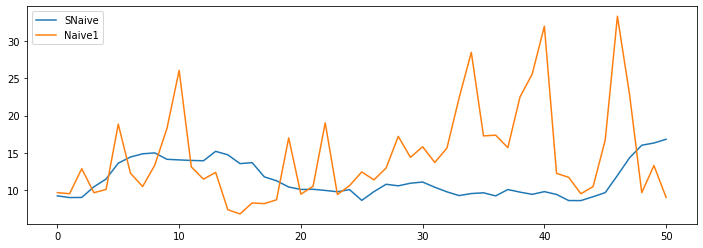

In [27]:
ax = pd.DataFrame(cv_scores_1).plot(figsize=(12,4))
pd.DataFrame(cv_scores_2).plot(ax=ax)
ax.legend(['SNaive', 'Naive1'])

In [28]:
model = SNaive(period=12)
model.fit(train)
preds = model.predict(horizon=12)

In [29]:
mean_absolute_error(test, preds)

15.130823489944726